นำเข้ารูปภาพที่ถ่ายด้วยกัน และ Add Noise

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import requests

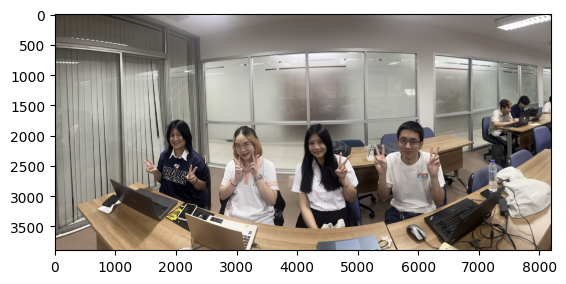

In [22]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import requests

url = 'https://drive.google.com/uc?export=download&id=1mA8jnFxsVE-StXnnmUJw1CPBCpzMJJUj'
response = requests.get(url)
if response.status_code != 200:
  print('Error: Image not found.')
  sys.exit(1)

img = cv2.imdecode(np.frombuffer(response.content, dtype=np.uint8), cv2.IMREAD_COLOR)
if img is None:
  print('Error: Image not decoded.')
  sys.exit(2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap=None)
plt.show()

ทำการ Add Noise

In [23]:
def s_and_p_noise(image, s_p_ratio=0.04):
#this implementation is not entirely correct because it assumes that
# only 0 OR 255 values are S&P noise.
    out = np.copy(image)
# Salt mode
    mask = np.random.rand(image.shape[0], image.shape[1]) <= s_p_ratio / 2
    out[mask] = 255
# Pepper mode
    mask = np.random.rand(image.shape [0], image.shape[1]) <= s_p_ratio / 2
    out[mask] = 0
    return out

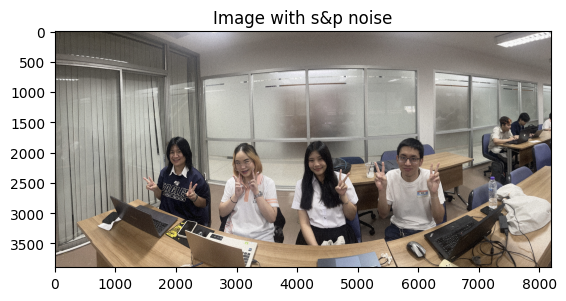

True

In [24]:
img_snp = s_and_p_noise(img, s_p_ratio=0.05)
img_snp_rgb = cv2.cvtColor(img_snp, cv2.COLOR_BGR2RGB)
plt.imshow(img_snp_rgb)
plt.title('Image with s&p noise')
plt.show()
cv2.imwrite("noise" + '_snp' + ".png", img_snp)

หา PNSR ค่า Noise ในภาพ

In [25]:
# Calculate PSNR.
from math import log10, sqrt

In [26]:
def PSNR(img_signal, img_noise):
    mse = np.mean((img_signal - img_noise)** 2)
    rmse = sqrt (mse)
    if(mse == 0): # No noise is present in the image.
      return 100 # No need to calculate PSNR.
    intensity_max = 255.
    psnr = 20 * log10(intensity_max/rmse)
    return psnr

In [27]:
def main():
    img_signal = img
    img_noise = img_snp
    psnr = PSNR(img_signal, img_noise)
    print ('PSNR ~ {:.2f} dB.'.format(psnr))

In [28]:
if __name__ == '__main__':
  main ( )

PSNR ~ 40.97 dB.


ทำการ Denoise ด้วย Guided Filter

In [2]:
!pip install opencv-python opencv-contrib-python

1. Apply Median Filtering to remove the salt-and-pepper noise.

2. Apply Guided Filtering afterward to further smooth the image while preserving edges.

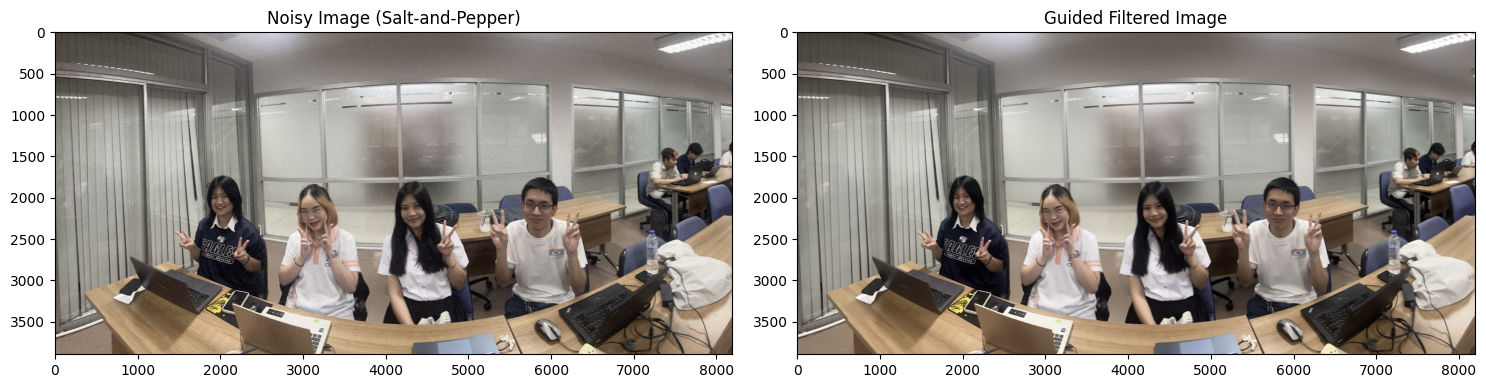

True

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the noisy image
noisy_image = cv2.imread('noise_snp.png')

# Step 1: Apply Median Filter to remove salt-and-pepper noise
median_filtered = cv2.medianBlur(noisy_image, 5)

# Step 2: Apply Guided Filter for edge-preserving smoothing
radius = 15
eps = 50
guided_filtered = cv2.ximgproc.guidedFilter(guide=median_filtered, src=median_filtered, radius=radius, eps=eps)

# Display the original, median-filtered, and guided-filtered images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Noisy Image (Salt-and-Pepper)')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(guided_filtered, cv2.COLOR_BGR2RGB))
plt.title('Guided Filtered Image')

plt.tight_layout()
plt.show()

# Save the final denoised image if needed
cv2.imwrite('final_denoised_image.jpg', guided_filtered)

In [30]:
# Calculate PSNR.
from math import log10, sqrt

In [31]:
def PSNR(img_signal, img_noise):
    mse = np.mean((img_signal - img_noise)** 2)
    rmse = sqrt (mse)
    if(mse == 0): # No noise is present in the image.
      return 100 # No need to calculate PSNR.
    intensity_max = 255.
    psnr = 20 * log10(intensity_max/rmse)
    return psnr

In [32]:
def main():
    img_signal = img_snp
    img_noise = guided_filtered
    psnr = PSNR(img_signal, img_noise)
    print ('PSNR ~ {:.2f} dB.'.format(psnr))

In [33]:
if __name__ == '__main__':
  main ( )

PSNR ~ 38.45 dB.


Reference
1. OpenCV Contributors. (n.d.). Guided Filter. In OpenCV Documentation. Retrieved September 3, 2024, from https://docs.opencv.org/master/d8/dc8/group__ximgproc__filter.html#ga4a4799f8d9c5aace71bbabb7b048d6e1